# This notebook is for detecting single eye blinks in the data

In [1]:
import sys
sys.path.append('../')

import config
config.reset_filter_states()
import filters as f
import numpy as np
import torch
import os
import pickle
from pathlib import Path

Starting creating streamer....
Using config.dataReader - random number


In [11]:
t = Path('../test_data/SingleBlinksData')
files = os.listdir(t)
files

['[f]SingleBlink091019_175505.pickle',
 '[f]SingleBlink091019_182844.pickle',
 '[f]SingleBlink091019_182716.pickle',
 '[f]SingleBlink091019_182530.pickle',
 '[f]SingleBlink091019_182955.pickle']

In [12]:
eyeBlinkFiles = []
for file in files:
    if('Single' in file):
        eyeBlinkFiles.append(file)

In [13]:
eyeBlinkFiles

['[f]SingleBlink091019_175505.pickle',
 '[f]SingleBlink091019_182844.pickle',
 '[f]SingleBlink091019_182716.pickle',
 '[f]SingleBlink091019_182530.pickle',
 '[f]SingleBlink091019_182955.pickle']

In [14]:
eyeBlinkFiles.sort()
fi = open(t/eyeBlinkFiles[-1],'rb')
d = pickle.load(fi)
d.shape

(60, 8, 250)

In [15]:
import matplotlib.pyplot as plt
plt.plot(d[:,0,:].reshape(-1))
plt.show()

<Figure size 640x480 with 1 Axes>

In [17]:
data = np.zeros((1,8,250))
config.reset_filter_states()
for file in eyeBlinkFiles:
    with open(t/file,'rb') as ef:
        d = pickle.load(ef)
        print(d.shape)
        d = f.apply_bandpass_filter(d,3,7)
        d = d[4:]
        data = np.vstack((data,d))
data = data[1:]

(120, 8, 250)
(60, 8, 250)
(60, 8, 250)
(60, 8, 250)
(60, 8, 250)


In [18]:
data.shape

(340, 8, 250)

In [19]:
146/4

36.5

In [20]:
labels = np.array([1,0,0,0]*(int(data.shape[0]/4)))

In [21]:
labels.shape

(340,)

# Testing out keras

In [22]:
import keras
from keras.layers import Convolution2D, Input, MaxPool2D, AvgPool2D,Dense,Flatten, BatchNormalization
from keras.models import Model
from keras.utils import np_utils

Using Theano backend.


In [23]:
inp = Input(shape=(1,250,1))
l1 = Convolution2D(32,(1,3),activation='relu',input_shape=(1,250))(inp) # 248
l2 = Convolution2D(64,(1,3),activation='relu')(l1) # 246
#bn1 = BatchNormalization()(l2)
p1 = MaxPool2D((1,2))(l2) # 123
l3 = Convolution2D(32,(1,3),activation='relu')(p1) # 121
l4 = Convolution2D(64,(1,3),activation='relu')(l3) # 119
#bn2 = BatchNormalization()(l4)
p2 = MaxPool2D((1,2))(l4) # 59
l5 = Convolution2D(32,(1,3),activation='relu')(p2) # 57
l6 = Convolution2D(64,(1,3),activation='relu')(l5) # 55
#bn3 = BatchNormalization()(l6)
p3 = MaxPool2D((1,2))(l6) # 27
l7 = Convolution2D(32,(1,3),activation='relu')(p3) # 25
l8 = Convolution2D(64,(1,3),activation='relu')(l7) # 23
#bn4 = BatchNormalization()(l8)
p4 = MaxPool2D((1,2))(l8) # 11
l9 = Convolution2D(32,(1,3),activation='relu')(p4) # 9 
lX = Convolution2D(64,(1,3),activation='relu')(l9) # 7
ap = AvgPool2D((1,7))(lX) # 1
flat = Flatten()(ap)
d1 = Dense(2,activation='softmax')(flat)
model = Model(inputs=inp,outputs=d1)
model.compile(loss='categorical_crossentropy',optimizer='rmsprop',metrics=['accuracy'])

In [24]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 1, 250, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 1, 248, 32)        128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 1, 246, 64)        6208      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 1, 123, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 1, 121, 32)        6176      
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 1, 119, 64)        6208      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 1, 59, 64)         0         
__________

In [25]:
#np.random.seed(42)
chan_0 = data[:,[0],:]
chan_0 = np.expand_dims(chan_0,axis=-1)
x_data = chan_0/200.0
y_data = np_utils.to_categorical(labels)
from sklearn.model_selection import train_test_split
X,x,Y,y = train_test_split(x_data,y_data,test_size=0.2,random_state=0)
#X = (X - X.mean())/X.std()
#x = (x - X.mean())/X.std()

In [26]:
model.fit(X,Y,epochs=10,batch_size=16,validation_data=(x,y),shuffle=True)

Train on 272 samples, validate on 68 samples
Epoch 1/10
272/272 [==============================] - 2s 7ms/step - loss: 0.5952 - acc: 0.7390 - val_loss: 0.3066 - val_acc: 0.8824
Epoch 2/10
272/272 [==============================] - 2s 7ms/step - loss: 0.2433 - acc: 0.9265 - val_loss: 0.2722 - val_acc: 0.9265
Epoch 3/10
272/272 [==============================] - 2s 7ms/step - loss: 0.1964 - acc: 0.9559 - val_loss: 0.2356 - val_acc: 0.9412
Epoch 4/10
272/272 [==============================] - 2s 7ms/step - loss: 0.1878 - acc: 0.9485 - val_loss: 0.2475 - val_acc: 0.9412
Epoch 5/10
272/272 [==============================] - 2s 9ms/step - loss: 0.1536 - acc: 0.9669 - val_loss: 0.2429 - val_acc: 0.9412
Epoch 6/10
272/272 [==============================] - 2s 7ms/step - loss: 0.1365 - acc: 0.9632 - val_loss: 0.2722 - val_acc: 0.9412
Epoch 7/10
272/272 [==============================] - 2s 7ms/step - loss: 0.1224 - acc: 0.9669 - val_loss: 0.2682 - val_acc: 0.9412
Epoch 8/10
272/272 [===========

In [28]:
out = model.predict(x)

predicted_labels = out.argmax(axis=-1)

real_labels = y.argmax(axis=-1)

from sklearn.metrics import confusion_matrix

cm = confusion_matrix(predicted_labels,real_labels)

cm

array([[50,  3],
       [ 2, 13]])

# Plotting wrong labels

In [29]:
# First get wrong predicted labels
wrong = (predicted_labels == real_labels)
np.where(wrong == False)

(array([12, 17, 27, 32, 61]),)

In [30]:
wrong_idx = np.where(wrong==False)
wrong_idx[0]

array([12, 17, 27, 32, 61])

In [31]:
wrong_data = x[wrong_idx[0]]

In [32]:
print(wrong_data.shape)
wrong_data = np.squeeze(wrong_data)
print(wrong_data.shape)

(5, 1, 250, 1)
(5, 250)


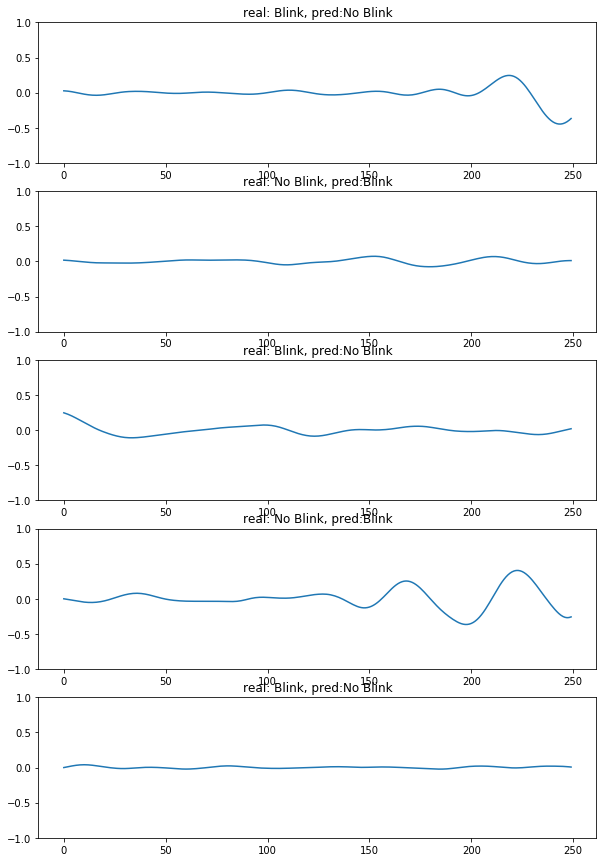

In [33]:
import matplotlib.pyplot as plt
%matplotlib inline
fig,ax = plt.subplots(wrong_data.shape[0],1,figsize=(10,15))
if(type(ax) != np.ndarray):
    ax = np.array([ax])
lab = {0:'No Blink',1:'Blink'}
for i in range(wrong_data.shape[0]):
    ax[i].plot(wrong_data[i])
    ax[i].set_title(f'real: {lab[real_labels[wrong_idx[0][i]]]}, pred:{lab[predicted_labels[wrong_idx[0][i]]]}')
    ax[i].set_ylim(-1,1)
plt.show()

# Hoow classification matrix works

In [ ]:
x = [0,1,0,1,0,0]
y = [0,1,0,1,1,0]

In [ ]:
cm = confusion_matrix(x,y)

In [ ]:
cm